In [1]:
pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
data_csv = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

In [3]:
data_csv.to_csv('/usr/local/lib/python3.9/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv')

In [5]:
import sys
sys.path.append("../")
from fairness_metrics import compute_metrics
from plot_metrics import confusion_matrix, plot_fairness_metrics, plot_protected_attribute
from processing_algos import Processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models import Models

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [6]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

In [7]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
session = tf.Session()

# **Select the Protected attribute:** `Race` or `Sex`

In [8]:
protected_attribute = 'sex'
import seaborn as sns

In [9]:
if protected_attribute == 'race':
  privileged_groups_race = [{'race': 1}]  # White
  unprivileged_groups_race = [{'race': 0}]  # Not white
elif protected_attribute == 'sex':
  privileged_groups_race = [{'sex': 1}]  # Male
  unprivileged_groups_race = [{'sex': 0}]  # Female
dataset = load_preproc_data_compas([protected_attribute])
dataset_orig_train, dataset_orig_test = dataset.split([0.7], shuffle = True)
print('Size of train set: {}\nSize of test set: {}'.format(dataset_orig_train.features.shape[0],
                                                                                       dataset_orig_test.features.shape[0]))

Size of train set: 3694
Size of test set: 1584


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


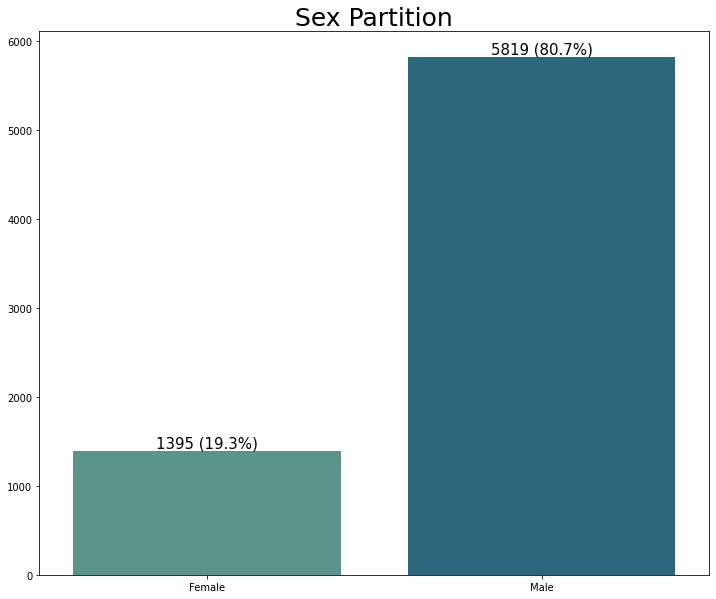

In [10]:
plot_protected_attribute(data_csv, protected_attribute)

## **Fairness Metrics on Original Dataset**

In [11]:
mean_diff, smoothed_empirical, disparate_impact = compute_metrics(dataset_orig_train,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff)
print("Equal Opportunity Difference = ", smoothed_empirical)
print("Disparate Impact = ", disparate_impact)

Statistical Parity Difference =  -0.13451350254654115
Equal Opportunity Difference =  0.3214117049155111
Disparate Impact =  0.79174005965382


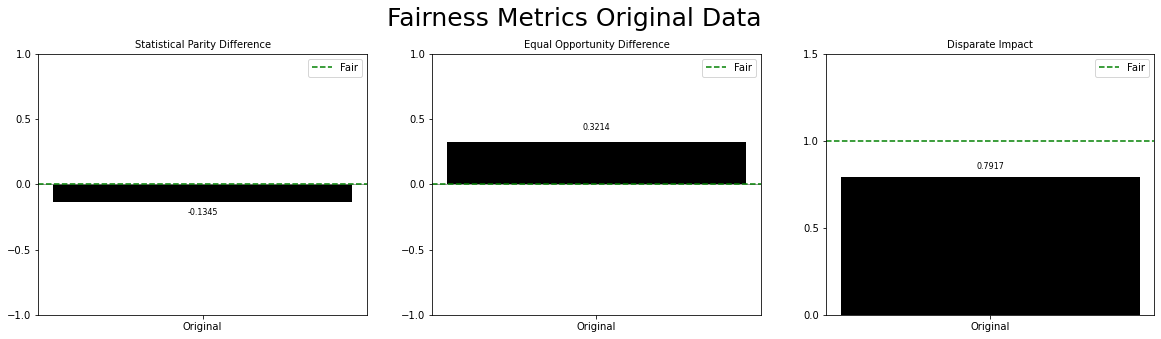

In [12]:
plot_fairness_metrics(np.array([mean_diff]), np.array([smoothed_empirical]), np.array([disparate_impact]), 
                      comp = False, processing_techinque = 'Original Data')

## **Processing Techniques**

## Reweighing Pre-Processing

In [13]:
processing = Processing(privileged_groups_race, unprivileged_groups_race)

In [14]:
transformed_train_data = processing.reweighing_processing(dataset_orig_train)
transformed_test_data = processing.reweighing_processing(dataset_orig_test)

In [15]:
mean_diff_mit, smoothed_empirical_mit, disparate_impact_mit = compute_metrics(transformed_train_data,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff_mit)
print("Equal Opportunity Difference = ", smoothed_empirical_mit)
print("Disparate Impact = ", disparate_impact_mit)

Statistical Parity Difference =  0.0
Equal Opportunity Difference =  8.650960756173554e-05
Disparate Impact =  1.0


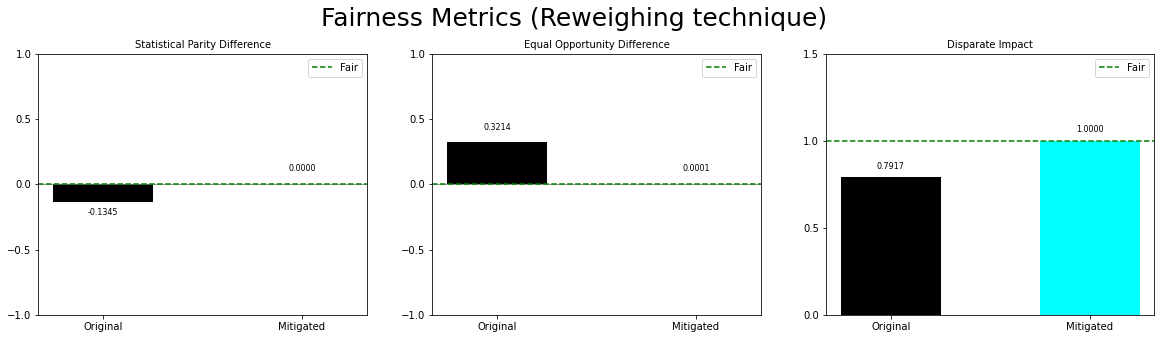

In [16]:
plot_fairness_metrics(np.array([mean_diff, mean_diff_mit]),
                      np.array([smoothed_empirical, smoothed_empirical_mit]),                    
                      np.array([disparate_impact, disparate_impact_mit]), comp = True, processing_techinque = '(Reweighing technique)')

## Training Models


### Logistic Regression

In [17]:
models_origin = Models(dataset_orig_train, dataset_orig_test)
models_transf = Models(transformed_train_data, transformed_test_data)

logistic_reg_orig, metrics_org_lg, confusion_matrix_org_lg = models_origin.logistic_regression()
logistic_reg_trans, metrics_trans_lg, confusion_matrix_trans_lg = models_transf.logistic_regression()

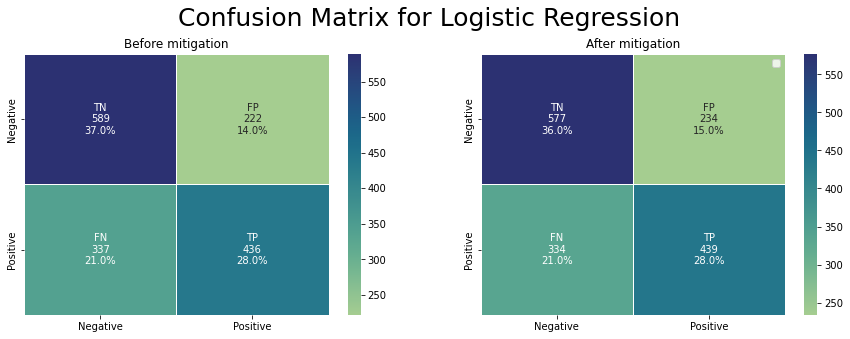

In [18]:
confusion_matrix(confusion_matrix_org_lg, confusion_matrix_trans_lg, 'Logistic Regression')

### Random Forest

In [19]:
models_origin = Models(dataset_orig_train, dataset_orig_test)
models_transf = Models(transformed_train_data, transformed_test_data)
rf_orig, metrics_org_rf, confusion_matrix_org_rf = models_origin.random_forest()
rf_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

In [20]:
metrics_org_rf

{'Accuracy': 0.6382575757575758,
 'Recall': 0.5834411384217335,
 'Precision': 0.6424501424501424,
 'F1 Score': 0.6115254237288137}

In [21]:
metrics_transf

{'Accuracy': 0.6414141414141414,
 'Recall': 0.5679172056921087,
 'Precision': 0.6523031203566122,
 'F1 Score': 0.6071922544951591}

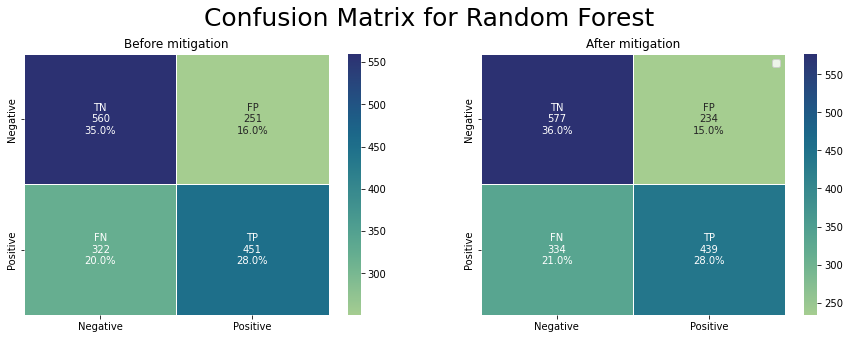

In [22]:
confusion_matrix(confusion_matrix_org_rf, confusion_matrix_transf, 'Random Forest')

### SVM

In [23]:
models_origin = Models(dataset_orig_train, dataset_orig_test)
models_transf = Models(transformed_train_data, transformed_test_data)
svm_orig, metrics_org_svm, confusion_matrix_org_svm = models_origin.svm()
svm_orig, metrics_transf, confusion_matrix_transf = models_transf.svm()

In [24]:
metrics_org_svm

{'Accuracy': 0.6306818181818182,
 'Recall': 0.6468305304010349,
 'Precision': 0.6157635467980296,
 'F1 Score': 0.6309148264984227}

In [25]:
metrics_transf

{'Accuracy': 0.6306818181818182,
 'Recall': 0.6468305304010349,
 'Precision': 0.6157635467980296,
 'F1 Score': 0.6309148264984227}

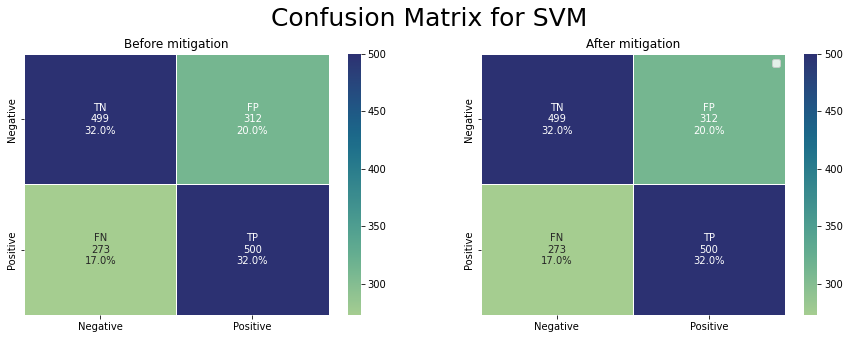

In [26]:
confusion_matrix(confusion_matrix_org_svm, confusion_matrix_transf, 'SVM')

## Opt Pre-Processing

In [27]:
optim_options = {
        "distortion_fun": get_distortion_compas,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]}
transformed_train_data = processing.optim_pre_processing(dataset_orig_train, optim_options)
transformed_test_data = processing.optim_pre_processing(dataset_orig_test, optim_options)

/usr/local/lib/python3.9/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/cvxpy/expressi

Optimized Preprocessing: Objective converged to 0.000000


/usr/local/lib/python3.9/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/cvxpy/expressi

Optimized Preprocessing: Objective converged to 0.000000


In [28]:
mean_diff_mit, smoothed_empirical_mit, disparate_impact_mit = compute_metrics(transformed_train_data,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff_mit)
print("Equal Opportunity Difference = ", smoothed_empirical_mit)
print("Disparate Impact = ", disparate_impact_mit)

Statistical Parity Difference =  -0.035292254949922386
Equal Opportunity Difference =  0.07760497082135953
Disparate Impact =  0.937396150767223


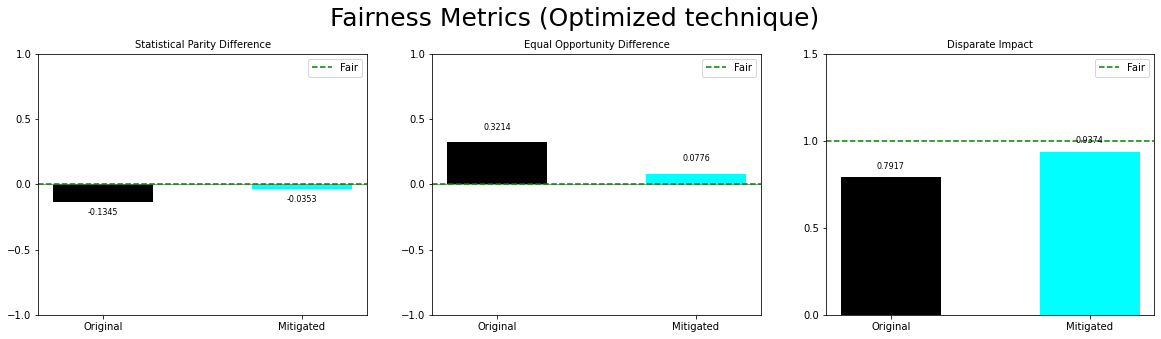

In [29]:
plot_fairness_metrics(np.array([mean_diff, mean_diff_mit]),
                      np.array([smoothed_empirical, smoothed_empirical_mit]),                    
                      np.array([disparate_impact, disparate_impact_mit]), comp = True, processing_techinque = '(Optimized technique)')

### Logistic Regression

In [30]:
models_transf = Models(transformed_train_data, transformed_test_data)
logistic_reg_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

In [31]:
metrics_transf

{'Accuracy': 0.6426767676767676,
 'Recall': 0.5639386189258312,
 'Precision': 0.6621621621621622,
 'F1 Score': 0.6091160220994475}

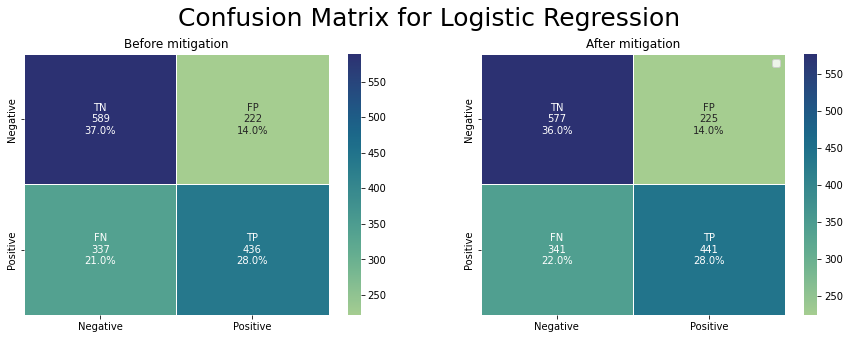

In [32]:
confusion_matrix(confusion_matrix_org_lg, confusion_matrix_transf, 'Logistic Regression')

### Random Forest

In [33]:
models_transf = Models(transformed_train_data, transformed_test_data)
rf_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

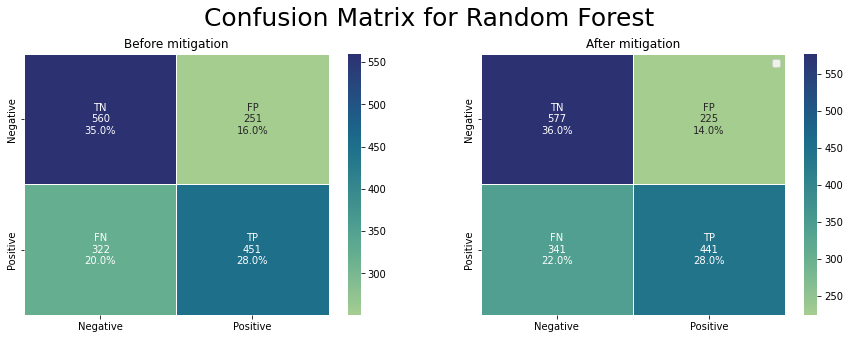

In [34]:
confusion_matrix(confusion_matrix_org_rf, confusion_matrix_transf, 'Random Forest')

### SVM

In [35]:
models_transf = Models(transformed_train_data, transformed_test_data)
svm_trans, metrics_transf, confusion_matrix_transf = models_transf.svm()

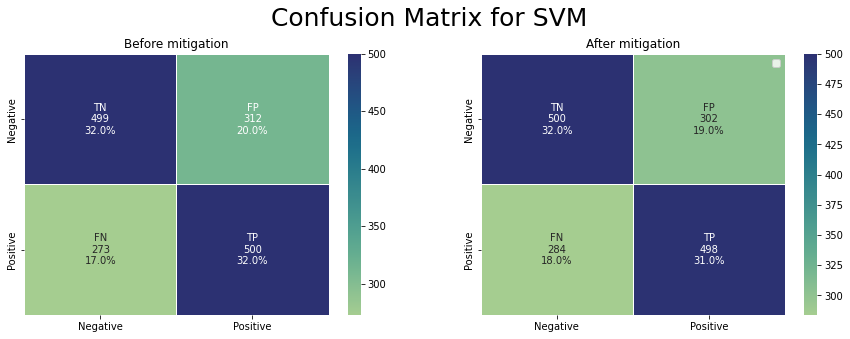

In [36]:
confusion_matrix(confusion_matrix_org_svm, confusion_matrix_transf, 'SVM')

## Adversarial In-Processing 

In [37]:
transformed_train, transformed_test = processing.adversarial_debiasing_processing(dataset_orig_train, dataset_orig_test, session, 'plain_classifier', True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.713565; batch adversarial loss: 0.764535
epoch 1; iter: 0; batch classifier loss: 0.630391; batch adversarial loss: 0.748253
epoch 2; iter: 0; batch classifier loss: 0.606131; batch adversarial loss: 0.735246
epoch 3; iter: 0; batch classifier loss: 0.639467; batch adversarial loss: 0.719442
epoch 4; iter: 0; batch classifier loss: 0.622406; batch adversarial loss: 0.696496
epoch 5; iter: 0; batch classifier loss: 0.646026; batch adversarial loss: 0.679143
epoch 6; iter: 0; batch classifier loss: 0.581616; batch adversarial loss: 0.663477
epoch 7; iter: 0; batch classifier loss: 0.584034; batch adversarial loss: 0.645827
epoch 8; iter: 0; batch classifier loss: 0.576636; batch adversarial loss: 0.636062
epoch 9; iter: 0; batch classifier loss: 0.651529; batch adversarial loss: 0.627886
epoch 10; iter: 0; batch classifier loss: 0.582512; batch adversarial loss: 0.599635
epoch 11; iter: 0; batch classifier loss: 0.522089; batch adversarial loss:

In [38]:
mean_diff_mit, smoothed_empirical_mit, disparate_impact_mit = compute_metrics(transformed_train,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff_mit)
print("Equal Opportunity Difference = ", smoothed_empirical_mit)
print("Disparate Impact = ", disparate_impact_mit)

Statistical Parity Difference =  -0.5470029314614454
Equal Opportunity Difference =  3.543430999423758
Disparate Impact =  0.44433946818448855


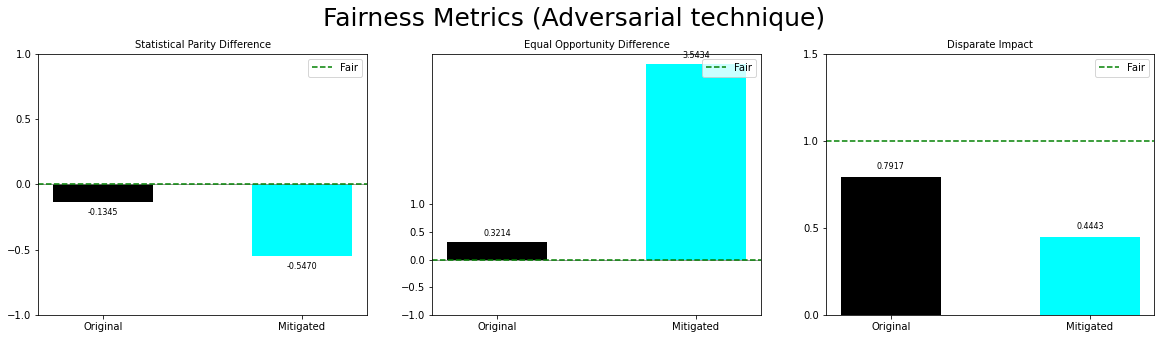

In [39]:
plot_fairness_metrics(np.array([mean_diff, mean_diff_mit]),
                      np.array([smoothed_empirical, smoothed_empirical_mit]),                    
                      np.array([disparate_impact, disparate_impact_mit]), comp = True, processing_techinque = '(Adversarial technique)')

In [40]:
models_transf = Models(transformed_train, transformed_test)
logistic_reg_trans, metrics_transf, confusion_matrix_transf = models_transf.logistic_regression()

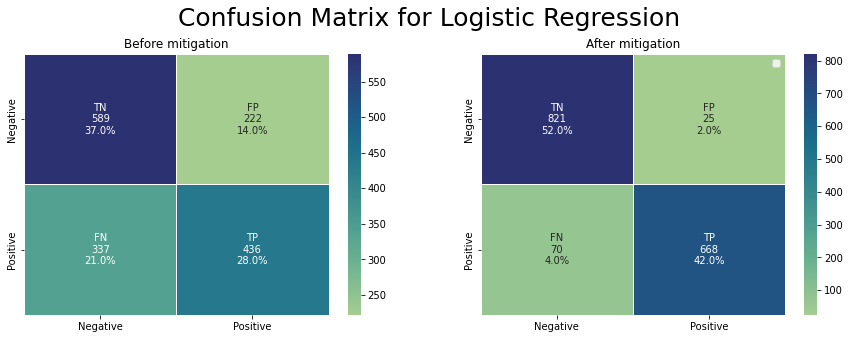

In [41]:
confusion_matrix(confusion_matrix_org_lg, confusion_matrix_transf, 'Logistic Regression')

In [42]:
models_transf = Models(transformed_train, transformed_test)
rf_trans, metrics_transf, confusion_matrix_transf = models_transf.random_forest()

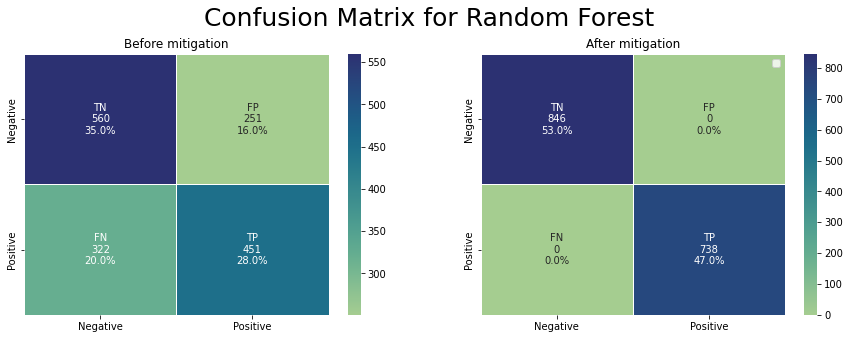

In [43]:
confusion_matrix(confusion_matrix_org_rf, confusion_matrix_transf, 'Random Forest')

In [44]:
models_transf = Models(transformed_train, transformed_test)
svm_trans, metrics_transf, confusion_matrix_transf = models_transf.svm()

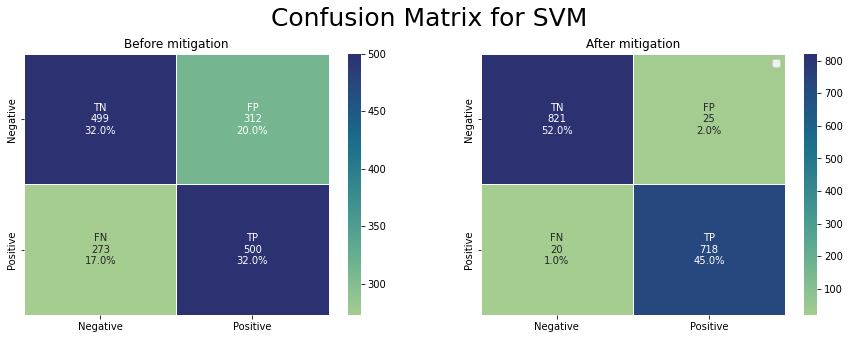

In [45]:
confusion_matrix(confusion_matrix_org_svm, confusion_matrix_transf, 'SVM')

# Calibrated Odds

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy = True)
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)
fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1, 1)

In [49]:
y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= 0.5] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= 0.5)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

In [50]:
transformed_train, transformed_test = processing.calibrated_eq_odds_processing(dataset_orig_train, 
                                                                               dataset_orig_train_pred, dataset_orig_test, cost_constraint = 'fnr', seed = 0)

In [51]:
mean_diff_mit, smoothed_empirical_mit, disparate_impact_mit = compute_metrics(transformed_train,  unprivileged_groups_race, privileged_groups_race)
print("Statistical Parity Difference = ", mean_diff_mit)
print("Equal Opportunity Difference = ", smoothed_empirical_mit)
print("Disparate Impact = ", disparate_impact_mit)

Statistical Parity Difference =  -0.48862115127175365
Equal Opportunity Difference =  6.53801780600042
Disparate Impact =  0.5113788487282463


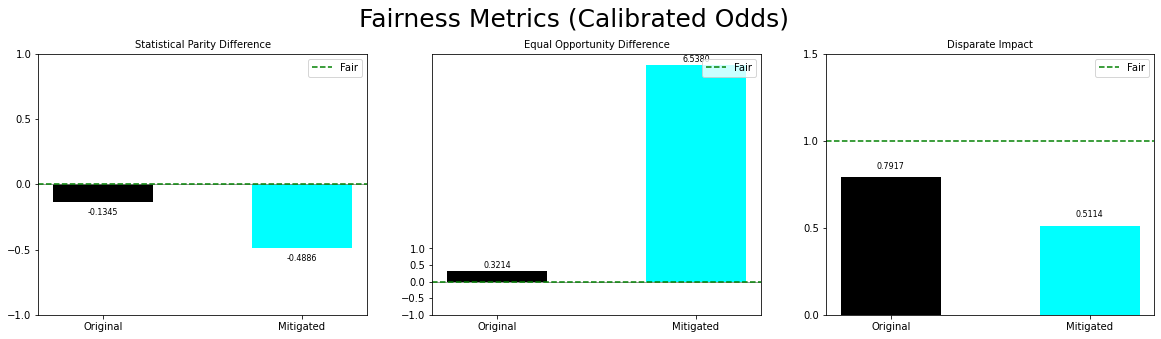

In [52]:
plot_fairness_metrics(np.array([mean_diff, mean_diff_mit]),
                      np.array([smoothed_empirical, smoothed_empirical_mit]),                    
                      np.array([disparate_impact, disparate_impact_mit]), comp = True, processing_techinque = '(Calibrated Odds)')